# QC

This is a notebook for implementing SNAP's Quality Control on the data products produced in this pipeline.

In [11]:
import os
import rasterio
import threading
import concurrent.futures
import random
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

os.environ["DST_DIR"] = "/atlas_scratch/cparr4/landfast_seaice/mahoney_preprocess/outputs"
out_dir = Path(os.getenv("DST_DIR"))
out_dir

PosixPath('/atlas_scratch/cparr4/landfast_seaice/mahoney_preprocess/outputs')

In [2]:
def meta_check(directory):

    all_meta = []
    
    fps = [x for x in directory.glob("*.tif")]

    read_lock = threading.Lock()

    def process(fp):
        src = rasterio.open(fp)
        with read_lock:
            profile = src.profile
            all_meta.append(profile)
    
    # We map the process() function over the list of files
    with concurrent.futures.ThreadPoolExecutor(
        max_workers=32
    ) as executor:
        executor.map(process, fps)

    return all_meta

In [3]:
landfast_meta = meta_check(out_dir)

In [4]:
meta_sample = dict(landfast_meta[0])
meta_sample

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 0.0,
 'width': 15786,
 'height': 7138,
 'count': 1,
 'crs': CRS.from_epsg(3338),
 'transform': Affine(100.0, 0.0, -859401.4481000006,
        0.0, -100.0, 2509919.0),
 'tiled': False,
 'compress': 'lzw',
 'interleave': 'band'}

In [5]:
assert(all([dict(x) == meta_sample for x in landfast_meta]) == True)

We've confirmed all rasters open with Rasterio, and by proxy, GDAL, and they have identical metadata to boot.

In [6]:
def get_n_random_geotiffs(directory, n):
    fps = [x for x in directory.glob("*.tif")]
    n_fps = random.sample(fps, n)
    return n_fps


def get_stat_summary_from_raster_list(rstrs):
    
    di = {}
    
    for fp in rstrs:
        fp_key = fp.name[:-4]
        di[fp_key] = {}
        with rasterio.open(fp) as src:
            arr = src.read(1).astype(float)
            arr[arr == src.nodata] = np.nan
            di[fp_key]["arr"] = arr
            di[fp_key]["min"] = np.round(np.nanmin(arr), 1)
            di[fp_key]["max"] = np.round(np.nanmax(arr), 1)
            di[fp_key]["mean"] = np.round(np.nanmean(arr), 1)
            di[fp_key]["sd"] = np.round(np.nanstd(arr), 1)
    return di

In [7]:
tiff_sample = get_n_random_geotiffs(out_dir, 9)

In [8]:
tiff_sample_di = get_stat_summary_from_raster_list(tiff_sample)

Because our anticipate data range is 0 and 1s, and 0s are "NoData" values that have made `np.nan` the min/max/mean for all rasters should be 1 and the sigma value should be 0.

In [10]:
for k in tiff_sample_di.keys():
    assert(tiff_sample_di[k]["min"] == tiff_sample_di[k]["mean"] == tiff_sample_di[k]["max"] == 1.0)
    assert(tiff_sample_di[k]["sd"] == 0)

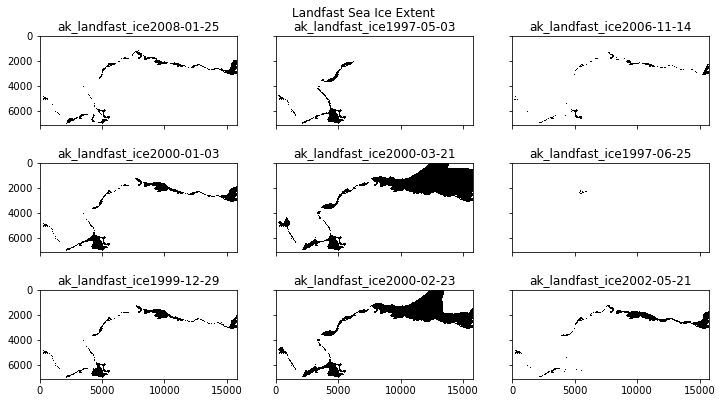

In [18]:
def plot_binary_maps(di):
    """Plot a random sample of 9 landfast ice GeoTIFFs."""
    
    fig, axs = plt.subplots(3, 3, figsize=(12, 7), sharex=True, sharey=True)
    fig.patch.set_facecolor("white")
    plt.suptitle("Landfast Sea Ice Extent", y=0.9)
    plt.subplots_adjust(hspace=0)
    
    for ax, k in zip(axs.flatten(), di.keys()):
        ax.imshow(di[k]["arr"], cmap="gray", interpolation="none")
        ax.set_title(k)

plot_binary_maps(tiff_sample_di)

Well it isn't a polished figure, but enough to convince me that the data passes the eyeball test!